### Imports

In [1]:
import itertools

import math
import numpy as np
import collections
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

#### Seed for Reproducibility

In [2]:
np.random.seed(42069)

#### Matplotlib Plot Style

In [3]:
# dark
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

# light
# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

### Load RWC Dict

In [4]:
# Load the RWC Dict Pickle File using NumPy
rwc_file_path = "0_ResNet50-CIFAR10rmae_dict_25.npy"

rwc_dict = np.load(rwc_file_path, allow_pickle=True)

In [5]:
rwc_dict = rwc_dict[()]

### Replace inf or NaN values with mean of the Layer

In [6]:
for i, (key, value) in enumerate(rwc_dict.items()):
    mean_sum = 0
    inf_arr = []
    arr_length = len(value)
    for j, val in enumerate(value):
        if not math.isinf(val):
            mean_sum += val
        else:
            inf_arr.append((key, j))

    total_mean = mean_sum / arr_length
    for i, j in inf_arr:
        rwc_dict[i][j] = total_mean

##### Remove the initial `conv1.weight` and last `linear.weight` layer

In [7]:
del rwc_dict[next(iter(rwc_dict))]
del rwc_dict[list(rwc_dict.keys())[-1]]
print(f"Number of layers/samples: {len(rwc_dict.keys())}")

Number of layers/samples: 35


### Replace Outliers
Here we are using the following strategy.

- Take the mean of the data for each layer
- Take the Standard Deviation of the data for each layer
- Subtract each data point from the mean of the data and take the absolute of the value
- If the value is greater than 2*(standard deviation), then we replace the value with the mean of the data

In [8]:
def replace_outliers(data, m=2):
    mean_data = np.mean(data)
    standard_dev = np.std(data)
    
    deviation_arr = abs(data - mean_data)
    bounds = m * standard_dev
    
    for index, deviation in enumerate(deviation_arr):
        if deviation > bounds:
            prev_next_avg = mean_data
            data[index] = prev_next_avg
    return data

In [9]:
for key, value in rwc_dict.items():
    updated_values = replace_outliers(value)
    rwc_dict[key] = updated_values

### Plot the RWC Curve

Number of features: 25


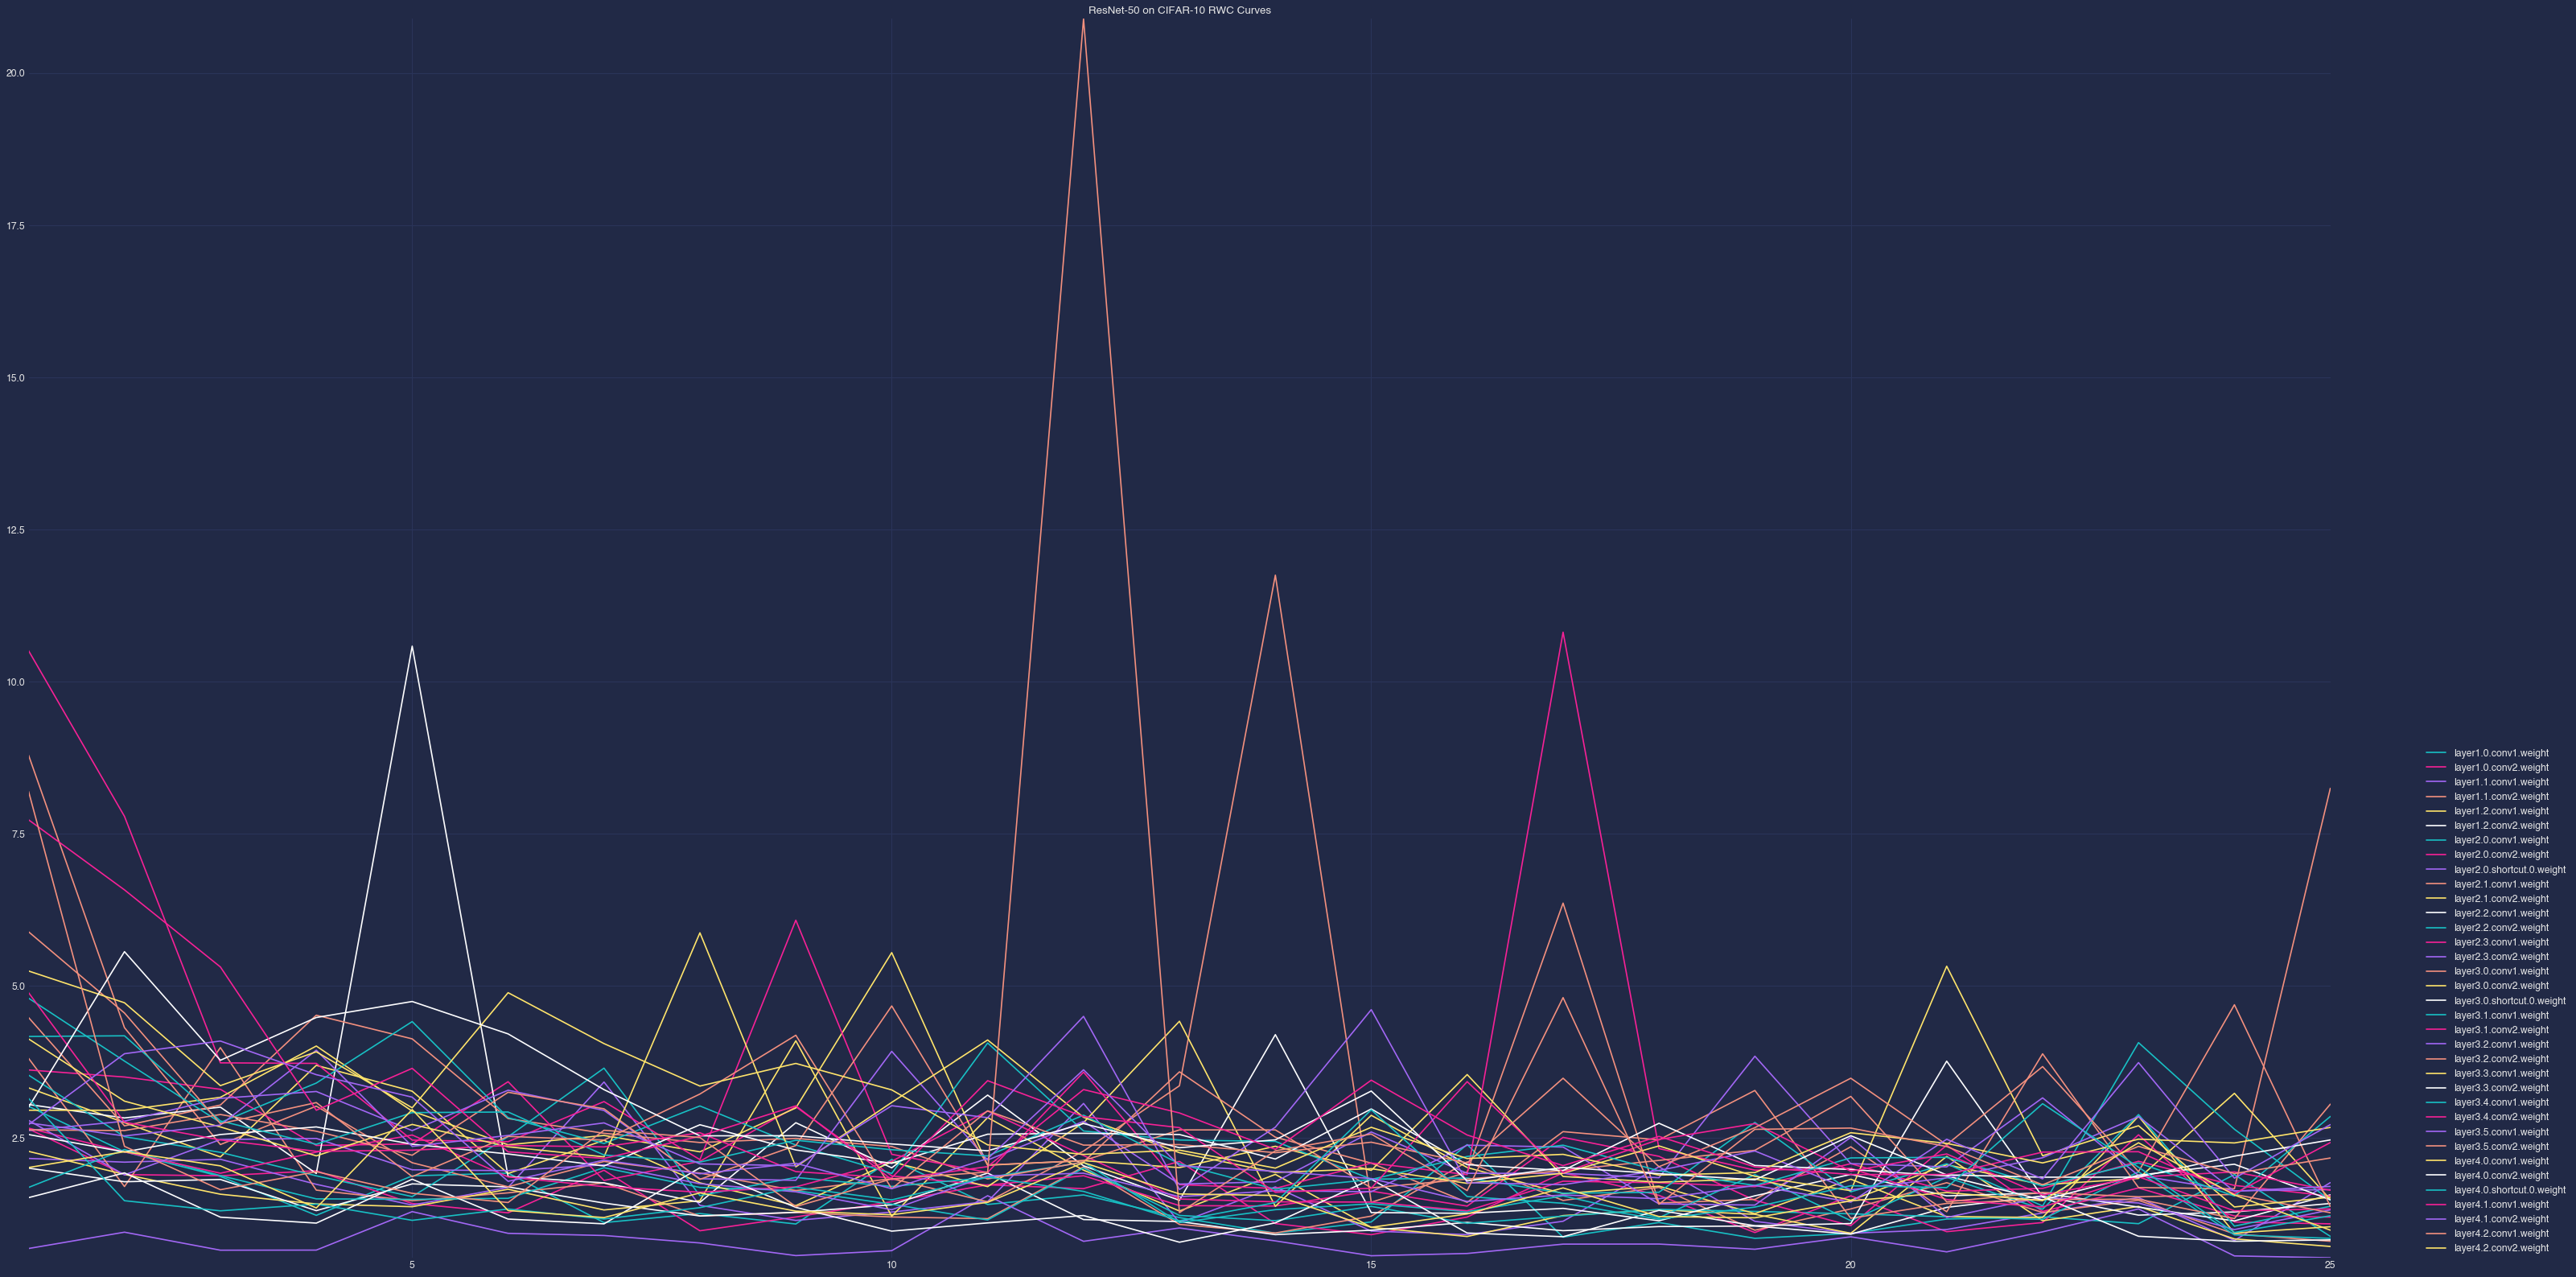

In [10]:
# Get the number of Features
features = len(rwc_dict[next(iter(rwc_dict))])
features_arr = np.arange(1,features+1)
print(f"Number of features: {len(features_arr)}")

fig = plt.figure(figsize=(40, 20), dpi=80)
ax = fig.add_subplot(111)
plt.autoscale(enable=True, tight=True)

for key, value in rwc_dict.items():
    line, = ax.plot(features_arr, value, linestyle = '-')
    line.set_label(key)
    ax.legend(loc=(1.04, 0))

plt.title("ResNet-50 on CIFAR-10 RWC Curves")
plt.tight_layout()
plt.savefig(f"./rwc_curves/rwc-res-cifar-10.png", bbox_inches='tight')
plt.show()

### Define a matrix of RWC Dict with shape `(layers, epochs)` or `(samples, features)`

In [11]:
# define a matrix using RWC Dict with the shape (samples, features)
rwc_matrix = []
for key, value in rwc_dict.items():
    rwc_matrix.append(value)
    
rwc_matrix = np.array(rwc_matrix)

print(f"KMeans Array Shape: {rwc_matrix.shape}")

KMeans Array Shape: (35, 25)


### KMeans and Average Intra Cluster Distance

In [12]:
def kmeans_and_scree_plot(data: list, K_range: list, n_init: int, max_iter: int):
    """
    Function runs KMeans++ on a range of k values and plots the Average Intra Cluster Distance
    Args:
        data (list): NumPy data to run KMeans on
        n_init (int): Number of different random inits for centroids
        max_iter (int): Maximum number of iterations for the KMeans algorithm
    """
    sum_squared_errors = {}
    for K in K_range:
        kmeans = KMeans(init="k-means++", n_clusters=K, n_init=n_init, max_iter=max_iter)
        kmeans.fit(data)
        sum_squared_errors[K] = kmeans.inertia_
        
    plt.figure()
    plt.plot(list(sum_squared_errors.keys()), list(sum_squared_errors.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    
    return plt
    

#### KMeans on the Original Dataset

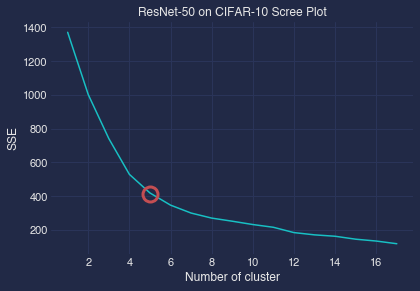

In [13]:
K = np.arange(1, 18)
plt = kmeans_and_scree_plot(data=rwc_matrix, K_range=K, n_init=10, max_iter=300)
plt.plot(5, 410, 'ro', markersize=15, markerfacecolor="none", markeredgewidth=3.0)
plt.tight_layout()
plt.title(f"ResNet-50 on CIFAR-10 Scree Plot")
plt.savefig(f"./scree_plots_original/res-scree-original-cifar-10.png", bbox_inches='tight')
plt.show()

#### Using PCA to reduce dimensions in the data then running KMeans

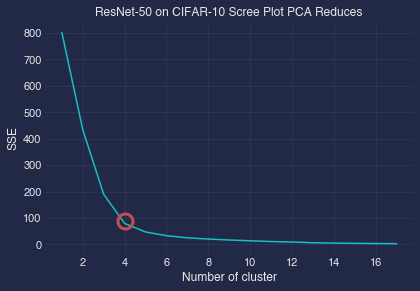

In [14]:
# running KMeans on Reduced Data
reduced_data = PCA(n_components=2).fit_transform(rwc_matrix)
plt = kmeans_and_scree_plot(data=reduced_data, K_range=K, n_init=10, max_iter=300)
plt.plot(4, 90, 'ro', markersize=15, markerfacecolor="none", markeredgewidth=3.0)
plt.tight_layout()
plt.title(f"ResNet-50 on CIFAR-10 Scree Plot PCA Reduces")
plt.savefig(f"./scree_plots_reduced/res-scree-pca-cifar-10.png", bbox_inches='tight')

plt.show()

### Visualize Data
Here we will perform dimensionality reduction using PCA and then plot the clusters with their respective centroids for the best KMeans on the reduced data

In [15]:
ideal_n_clusters = 4
init = 10
max_it = 300

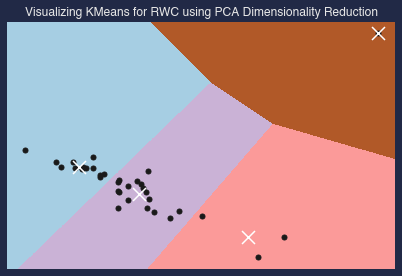

In [16]:
reduced_data = PCA(n_components=2).fit_transform(rwc_matrix)
kmeans = KMeans(init="k-means++", n_clusters=ideal_n_clusters, n_init=init, max_iter=max_it)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower")

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=10)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
            color="w", zorder=10)
plt.title("Visualizing KMeans for RWC using PCA Dimensionality Reduction")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.tight_layout()
plt.savefig(f"./clusters_PCA/res_cluster-cifar-10.png", bbox_inches='tight')
plt.show()


In [17]:
kmeans_original = KMeans(init="k-means++", n_clusters=ideal_n_clusters, n_init=init, max_iter=max_it)
kmeans_original.fit(rwc_matrix)

centroids = kmeans_original.cluster_centers_

### List Layers in Each Cluster

In [18]:
labels_kmeans = kmeans_original.predict(rwc_matrix)
rwc_layers_keys = np.asarray(list(rwc_dict.keys()))

clusters_dict = {}
for label, key in zip(labels_kmeans, rwc_layers_keys):
    if not label in clusters_dict:
        clusters_dict[label] = [key]
    else:
        clusters_dict[label].append(key)

clusters_dict = collections.OrderedDict(sorted(clusters_dict.items()))

In [19]:
for key, value in clusters_dict.items():
    label = "\033[1m" + f"Cluster {key}:" + "\033[0m"
    print(f"{label}\n")
    print(f"Centroid Coordinates: ({round(float(centroids[key][0]),4)}, {round(float(centroids[key][1]),4)})\n")
    keys_str = ", ".join(value)
    print(keys_str)
    print("\n-----------------\n")

Cluster 0:

Centroid Coordinates: (2.4293, 1.9515)

layer1.0.conv1.weight, layer1.0.conv2.weight, layer1.1.conv1.weight, layer1.1.conv2.weight, layer1.2.conv1.weight, layer1.2.conv2.weight, layer2.0.conv1.weight, layer2.0.shortcut.0.weight, layer2.2.conv2.weight, layer2.3.conv1.weight, layer2.3.conv2.weight, layer3.0.shortcut.0.weight, layer4.0.shortcut.0.weight, layer4.2.conv2.weight

-----------------

Cluster 1:

Centroid Coordinates: (9.6507, 6.0516)

layer2.1.conv1.weight, layer3.1.conv2.weight

-----------------

Cluster 2:

Centroid Coordinates: (8.1972, 2.3657)

layer4.2.conv1.weight

-----------------

Cluster 3:

Centroid Coordinates: (3.9224, 3.5611)

layer2.0.conv2.weight, layer2.1.conv2.weight, layer2.2.conv1.weight, layer3.0.conv1.weight, layer3.0.conv2.weight, layer3.1.conv1.weight, layer3.2.conv1.weight, layer3.2.conv2.weight, layer3.3.conv1.weight, layer3.3.conv2.weight, layer3.4.conv1.weight, layer3.4.conv2.weight, layer3.5.conv1.weight, layer3.5.conv2.weight, layer4.

#### Plot RWC Curve again with the KMeans Clusters

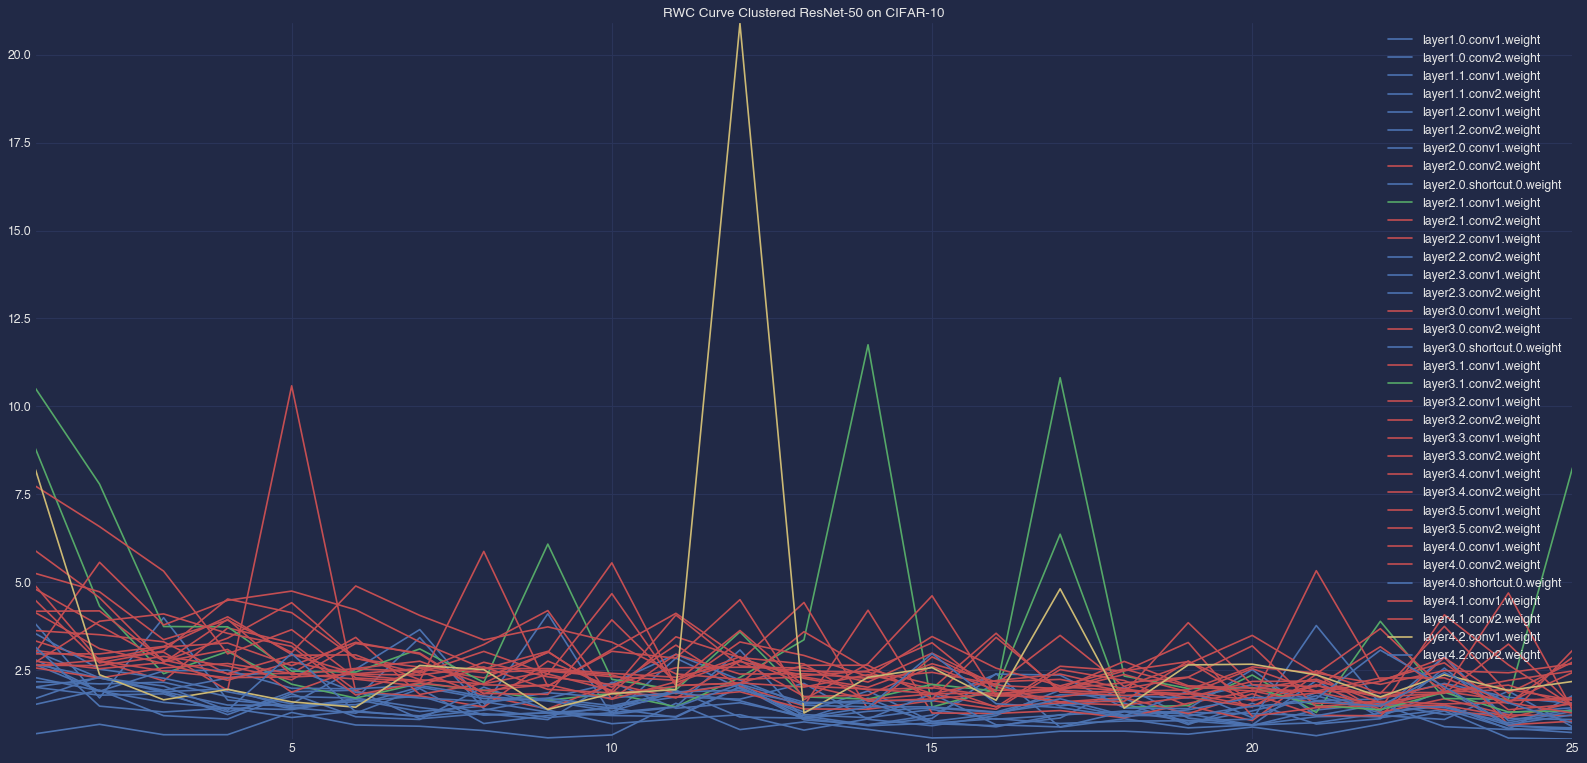

In [20]:
fig = plt.figure(figsize=(20, 10), dpi=80)
ax = fig.add_subplot(111)

plt.autoscale(enable=True, tight=True)
kmeans_labels = kmeans_original.labels_

colors = ['b', 'g', 'y', 'r', 'w', 'm','c']
count = 0

for key, value in rwc_dict.items():
    line, = ax.plot(features_arr, value, linestyle = '-', color=colors[kmeans_labels[count]])
    line.set_label(key)
    ax.legend()
    count += 1
plt.tight_layout()
plt.title("RWC Curve Clustered ResNet-50 on CIFAR-10")

plt.savefig(f"./cluster_graphs/res-clustered-cifar-10.png", bbox_inches='tight')
plt.show()